In [1]:
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import numpy as np
import scipy
import sys
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
#function will add 1 as column vector to the matrix
def addOneToMatrix(X):
    X = np.hstack((np.ones((X.shape[0],1)),X))
    return X

# likehood function to calc probability
def calcP(w,x):
    p = 1/(1+np.exp(-w.T@x))
    return p

# gradient descent function 
def gradientDescent(w,X,t,m,alpha):
    for m in range(m):
        sigma = 0
        for n in range(X.shape[0]):
            sigma = sigma + X[n,:]*(calcP(w,X[n,:]) - t[n]) 
        w = w - alpha * sigma
        
    return w

# function will return scramble data (X) ,and scramble the tag vector (t) respectively
# the data will scramble as first from (classical / blues) secound from ( disco / pop) until finish 
def scramble(X,t):
    tempX = np.zeros(X.shape)
    tempT = np.zeros(t.shape)
    
    for i in range(0,len(t),2):
        tempX[i,:] = X[int(i/2),:]
        tempX[i+1,:] = X[int(i/2) + 80,:]
        tempT[i] = t[int(i/2)]
        tempT[i+1] = t[int(i/2) + 80]
    return [tempX,tempT]


# function will return probability matrix get X - properties, w - coefficients vector
def probabilityMatrix(X,w):
    P = np.ones(X_train.shape[0]) # utilized  matrix size
    
    for i in range(X.shape[0]):
        P[i] = calcP(w,X[i,:])
    return P

# return confusion matrix where X- properties, t - the tag , Thresold , Pmatrix - probability matrix
def confusionMatrix(X,t,threshold,Pmatrix):
    conf = np.zeros((2,2)) # initialization of conffusion matrix size
    
    for i in range(X.shape[0]):
        if (Pmatrix[i] > threshold): # if predict one
            conf[0,np.mod(int(t[i]+1),2)] += 1
        else: # if predict zero
            conf[1,np.mod(int(t[i]+1),2)] += 1
    return conf

# function will recive X- data, t- tag vector, w - coefficients, compute and return the mse
def mse(X,t,w):
    mse = 0
    for n in range(X.shape[0]):
        mse = mse + ((calcP(w,X[n,:]) - t[n])**2)
    mse = mse / X.shape[0]
    return mse

# function computes the accuracy of the classifier using confustion matrix
def accuracy(matrix):
    TP = matrix[0,0]
    TN = matrix[1,1]
    return (TP + TN) / matrix.sum()

# function will recived tag vector , probability matrix, and the choosen alpha and return the cross entropy value
def crossEntropy(y,Pmatrix):
    ce = 0
    for n in range(len(y)):
        ce = ce - y[n]*np.log(Pmatrix[n] + 1e-08) - (1-y[n])*(np.log(1 - Pmatrix[n] + 1e-08))
    return ce

#function computes the True Positive and False Positive rates according to given matrix
def initTPAndFP(conf_matrix):
    TP_rate = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
    FP_rate = conf_matrix[0,1] / (conf_matrix[0,1] + conf_matrix[1,1])
    return [TP_rate,FP_rate]

#function computes the rates TP,FP for each optional threshold
def ROC(X,t,Pmatrix):
    thresholds = np.arange(0.1,1,0.01)
    TP_rates = np.zeros(len(thresholds))
    FP_rates = np.zeros(len(thresholds))
    
    for i in range(len(thresholds)):
        [TP_rates[i],FP_rates[i]] = initTPAndFP(confusionMatrix(X,t,thresholds[i],Pmatrix))
    return [TP_rates,FP_rates]

#function will recive w - coefficients, file name and export csv file
def exportCSV(w,file_name):
    file_data = pd.DataFrame(w)
    file_data.to_csv(str(file_name), index=False)

# function will find optimum of alpha and number of steps in gradient descent algoritem 
# by compering accuracy and cross entropy
def findOptimumVars(w0,X_train,t_train,alphas, steps ):

    min_acc = 0 #initial the minimum accuracy to 0
    max_ce = 100000 # initial the maximum - or larger enough as maximum cross entropy 
    threshold = 0.5
    
    arr_acc = np.zeros(len(steps))
    arr_ce = np.zeros(len(steps))
    colors = ['b','g','r','c','m','y']
    fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,10))

    for a in range(len(alphas)):
        arr_acc = np.zeros(len(steps))
        arr_ce = np.zeros(len(steps))
        for s in range(len(steps)):
            temp_w = gradientDescent(w0,X_train,t_train,int(steps[s]),alphas[a])
            Pmatrix = probabilityMatrix(X_train,temp_w)
            conf_matrix = confusionMatrix(X_train,t_train,threshold,Pmatrix)
            arr_acc[s] = accuracy(conf_matrix)
            arr_ce[s] = crossEntropy(t_train , Pmatrix)

            if (min_acc <= arr_acc[s]): #check for better accuracy
                if(max_ce > arr_ce[s]): # check for better cross entropy
                    alpha_optimal = alphas[a]
                    m_optimal = steps[s]
                    min_acc = arr_acc[s]
                    max_ce = arr_ce[s]

        ax[0].plot(steps,arr_acc,c=colors[a],label='alpha = ' + str(alphas[a]))
        ax[1].plot(steps,arr_ce,c=colors[a],label='alpha = ' + str(alphas[a]))
    ax[0].set_title('Classifier Accuracy vs. Gradient Descent steps for w0 = ' + str(w0[0]),fontsize=15)
    ax[0].set_xlabel('Gradient Descent M steps',fontsize=12)
    ax[0].set_ylabel('Accuracy',fontsize=12)
    ax[0].grid()
    ax[0].legend()               
    ax[1].set_title('Classifier Cross-Entropy vs. Gradient Descent steps for w0 = ' + str(w0[0]),fontsize=15)
    ax[1].set_xlabel('Gradient Descent M steps',fontsize=12)
    ax[1].set_ylabel('Cross-Entropy',fontsize=12)
    ax[1].grid()
    ax[1].legend()
    return[min_acc,max_ce,alpha_optimal,m_optimal]
                        


# Traning Set 1

In [3]:
# Q2
# a
# load the data from train set 1
trainset1 = np.loadtxt("matlab/MFCC_Features_1.csv", delimiter =',' , skiprows = 1)

# initialization Tag vectors for classical -0, disco - 1
tags = np.zeros(trainset1.shape[0])
tags[80:] = 1

# b
# scramble the data
[data,tag] = scramble(trainset1 , tags)

# create train series from 75% of the scramble data and tags, 25% will be the test series
X_train = data[:int((len(tag)*0.75)),:]
t_train = tag[:int((len(tag)*0.75))]
X_test = data[int((len(tag)*0.75)):,:]
t_test = tag[int((len(tag)*0.75)):]


In [4]:
# find alpha, w0, m for the optimun 
# first we initiated of gradient descent varibles
alpha = 0.01
m = 100
w0 = np.zeros(data.shape[1])+0.0001 # we choose value that close to the data
threshold = 0.5

# first we will check the initial parameter and how close the accuracy of the classifier

cross_entropy = np.ones(m)
acc = np.ones(m)

# 10 jump each one is by 1000 more 
for i in range(10):
    
    new_w = gradientDescent(w0,X_train,t_train,((i+1)*10000),alpha)
    P_train = probabilityMatrix(X_train,new_w)
    conf_matrix_new = confusionMatrix(X_train,t_train,threshold,P_train)
    cross_entropy[i] = crossEntropy(t_train , P_train)
    acc[i] = accuracy(conf_matrix_new)
    print('confusion matrix for train series for m =:' + str((i+1)*10000) +' \n' + str(conf_matrix_new))
    print('cross entropy: ' + str(cross_entropy[i]))
    print('accuracy: ' + str(acc[i]) + '\n\n')

confusion matrix for train series for m =:10000 
[[20.  1.]
 [40. 59.]]
cross entropy: 238.1863662500672
accuracy: 0.6583333333333333


confusion matrix for train series for m =:20000 
[[33.  3.]
 [27. 57.]]
cross entropy: 190.299581521052
accuracy: 0.75


confusion matrix for train series for m =:30000 
[[32.  1.]
 [28. 59.]]
cross entropy: 186.26703689649588
accuracy: 0.7583333333333333


confusion matrix for train series for m =:40000 
[[32.  1.]
 [28. 59.]]
cross entropy: 182.04072983593812
accuracy: 0.7583333333333333


confusion matrix for train series for m =:50000 
[[32.  1.]
 [28. 59.]]
cross entropy: 176.57826655685523
accuracy: 0.7583333333333333


confusion matrix for train series for m =:60000 
[[32.  1.]
 [28. 59.]]
cross entropy: 172.53596445361407
accuracy: 0.7583333333333333


confusion matrix for train series for m =:70000 
[[32.  1.]
 [28. 59.]]
cross entropy: 172.3435036908561
accuracy: 0.7583333333333333


confusion matrix for train series for m =:80000 
[[32.  1.]

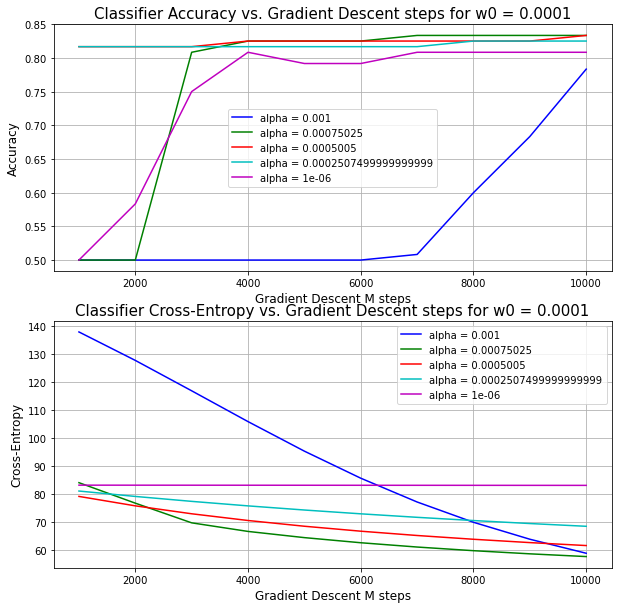

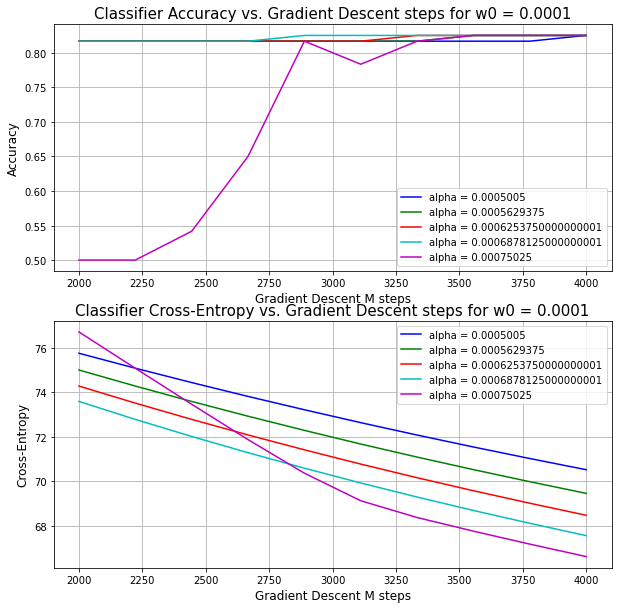

In [5]:
# find the optimum varibles by given data
# alpha between 0.0005005 - 0.00075025 withe 5 values
# alpha between 1000 - 10000 withe 10 values
alphas = np.linspace(0.001,0.000001,5)
steps = np.linspace(1000 , 10000, 10)
[op_accuracy,op_ce,op_alpha,op_m] = findOptimumVars(w0,X_train,t_train,alphas, steps)

# find the optimum varibles by given data after 1 set check
# alpha between 0.0005005 - 0.00075025 withe 5 values
# alpha between 2000 - 4000 withe 10 values
alphas = np.linspace(0.0005005,0.00075025,5)
steps = np.linspace(2000 , 4000, 10)
[op_accuracy,op_ce,op_alpha,op_m] = findOptimumVars(w0,X_train,t_train,alphas, steps)
best_alpha = op_alpha
best_m = op_m

In [6]:
# display accurency, mse of test and train series

w = gradientDescent(w0,X_train,t_train,int(op_m),op_alpha) # set gradient descent with optimal founded params
P_train = probabilityMatrix(X_train,w)
P_test = probabilityMatrix(X_test,w)

# Q3 - c
conf_mat_test = confusionMatrix(X_test,t_test,threshold,P_test)
conf_mat_train = confusionMatrix(X_train,t_train,threshold,P_train)
# print the accuracy of the two series
print('train Accuracy = ' + str(accuracy(conf_mat_test)))
print('Test Accuracy = ' + str(accuracy(conf_mat_train)))

#print the mse of the two series
mse_train = mse(X_train,t_train,w)
mse_test = mse(X_test,t_test,w)
print('mse_train = ' + str(mse_train))
print('mse_test = ' + str(mse_test))

train Accuracy = 0.85
Test Accuracy = 0.825
mse_train = 0.18369029555324004
mse_test = 0.15874447824738638


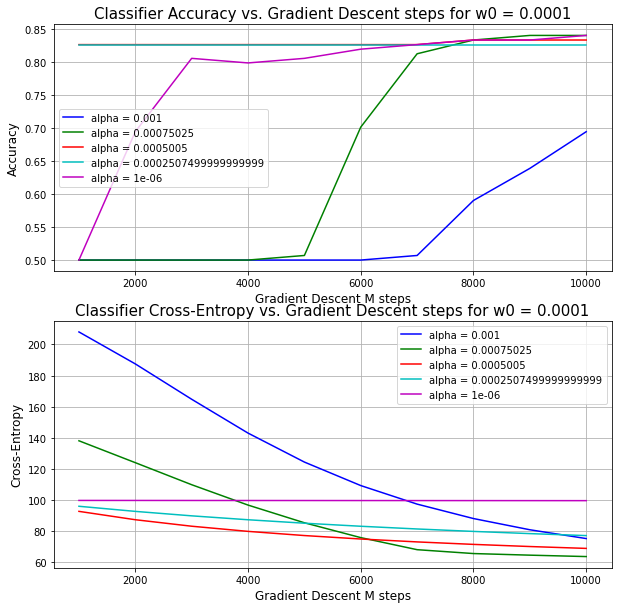

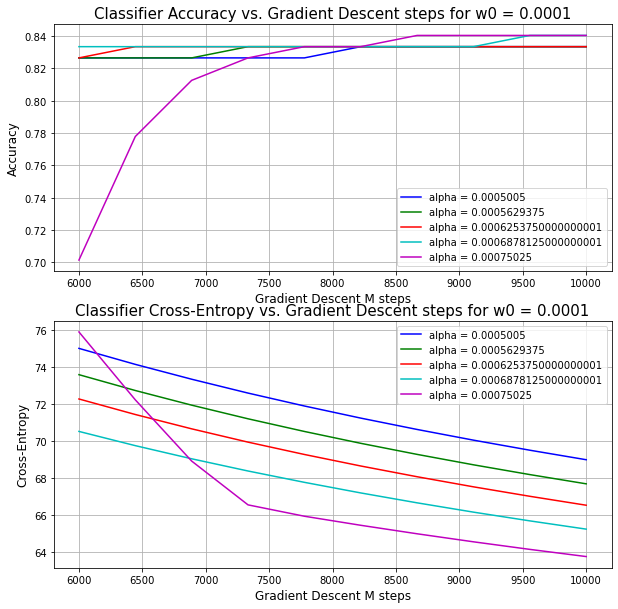

In [7]:
# change the test and the train series to 90% train and 10% test
X_train = data[:int((len(tag)*0.9)),:] 
t_train = tag[:int((len(tag)*0.9))]
X_test = data[int((len(tag)*0.9)):,:]
t_test = tag[int((len(tag)*0.9)):] 

# find the optimum varibles by given data
# alpha between 0.0005005 - 0.00075025 withe 5 values
# alpha between 1000 - 10000 withe 10 values
alphas = np.linspace(0.001,0.000001,5)
steps = np.linspace(1000 , 10000, 10)
[op_accuracy,op_ce,op_alpha,op_m] = findOptimumVars(w0,X_train,t_train,alphas, steps)


# find the optimum varibles by given data after 1 set check
# alpha between 0.0005005 - 0.00075025 withe 5 values
# alpha between 6000 - 10000 withe 10 values
alphas = np.linspace(0.0005005,0.00075025,5)
steps = np.linspace(6000 , 10000, 10)
[op_accuracy,op_ce,op_alpha,op_m] = findOptimumVars(w0,X_train,t_train,alphas, steps)


In [8]:
# display accurency, mse of test and train series

w = gradientDescent(w0,X_train,t_train,int(op_m),op_alpha) # set gradient descent with optimal founded params
P_train = probabilityMatrix(X_train,w)
P_test = probabilityMatrix(X_test,w)

#Q3- c
conf_mat_test = confusionMatrix(X_test,t_test,threshold,P_test)
conf_mat_train = confusionMatrix(X_train,t_train,threshold,P_train)
# print the accuracy of the two series
print('train Accuracy = ' + str(accuracy(conf_mat_test)))
print('Test Accuracy = ' + str(accuracy(conf_mat_train)))

#print the mse of the two series
mse_train = mse(X_train,t_train,w)
mse_test = mse(X_test,t_test,w)
print('mse_train = ' + str(mse_train))
print('mse_test = ' + str(mse_test))

train Accuracy = 0.8125
Test Accuracy = 0.8402777777777778
mse_train = 0.13979125647831675
mse_test = 0.1440807655260494


Text(0.5, 0, 'M')

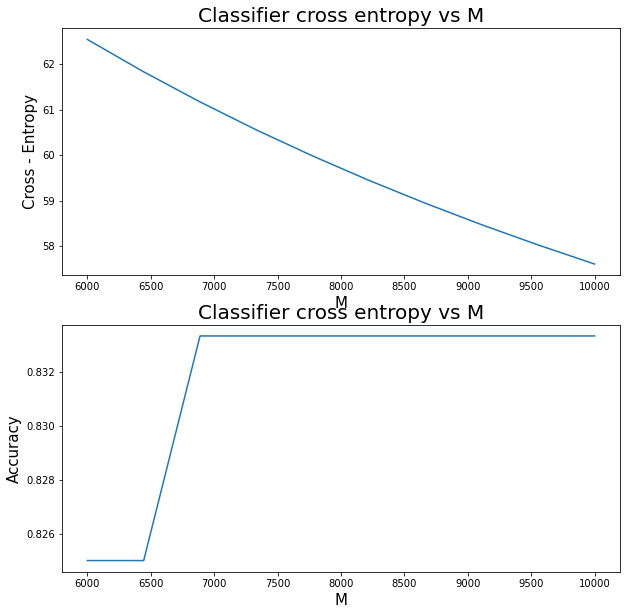

In [9]:
# Q3
# change for the first data butter sulotions
X_train = data[:int((len(tag)*0.75)),:]
t_train = tag[:int((len(tag)*0.75))]
X_test = data[int((len(tag)*0.75)):,:]
t_test = tag[int((len(tag)*0.75)):]

w = gradientDescent(w0,X_train,t_train,int(op_m),op_alpha) # set gradient descent with optimal founded params
#a
exportCSV(w,'TrainedClassiferCoefficients_TrainData1.csv')

#b
acc = np.zeros(len(steps))
ce = np.zeros(len(steps))

for i in range(len(steps)):
    w_ = gradientDescent(w0,X_train,t_train,int(steps[i]),best_alpha)
    Pmatrix = probabilityMatrix(X_train,w_)
    conf_matrix_ = confusionMatrix(X_train,t_train,threshold,Pmatrix)
    ce[i] = crossEntropy(t_train , Pmatrix)
    acc[i] = accuracy(conf_matrix_)

fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,10))


ax[0].plot(steps,ce)
ax[0].set_title('Classifier cross entropy vs M',fontsize=20)
ax[0].set_ylabel('Cross - Entropy',fontsize=15)
ax[0].set_xlabel('M',fontsize=15)
ax[1].plot(steps,acc)
ax[1].set_title('Classifier cross entropy vs M',fontsize=20)
ax[1].set_ylabel('Accuracy',fontsize=15)
ax[1].set_xlabel('M',fontsize=15)

confusion matrix for train series: 
[[57. 17.]
 [ 3. 43.]]
confusion matrix for test series: 
[[20.  3.]
 [ 0. 17.]]


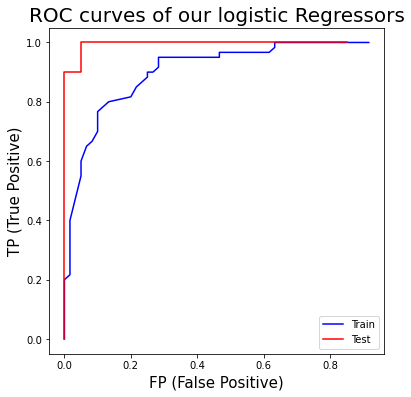

In [13]:
#Q3 - d

P_train = probabilityMatrix(X_train,w)
conf_mat_train = confusionMatrix(X_train,t_train,threshold,P_train)
P_test = probabilityMatrix(X_train,w)
conf_mat_test = confusionMatrix(X_test,t_test,threshold,P_test)

print('confusion matrix for train series: \n' + str(conf_mat_train))
print('confusion matrix for test series: \n' + str(conf_mat_test))

[TP_rates_train,FP_rates_train] = ROC(X_train,t_train,P_train)
[TP_rates_test,FP_rates_test] = ROC(X_test,t_test,P_test)
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(FP_rates_train,TP_rates_train,label='Train',c='b')
ax.plot(FP_rates_test,TP_rates_test,label='Test',c='r')
ax.set_title('ROC curves of our logistic Regressors',fontsize=20)
ax.set_xlabel('FP (False Positive)',fontsize=15)
ax.set_ylabel('TP (True Positive)',fontsize=15)
ax.legend()


# Train Set 2

In [18]:
# Q2
# a
# load the data from train set 1
trainset2 = np.loadtxt("matlab/MFCC_Features_2.csv", delimiter =',' , skiprows = 1)

# initialization Tag vectors for classical -0, disco - 1
tags = np.zeros(trainset2.shape[0])
tags[80:] = 1

# b
# scramble the data
[data,tag] = scramble(trainset2 , tags)

# create train series from 75% of the scramble data and tags, 25% will be the test series
X_train = data[:int((len(tag)*0.75)),:]
t_train = tag[:int((len(tag)*0.75))]
X_test = data[int((len(tag)*0.75)):,:]
t_test = tag[int((len(tag)*0.75)):]

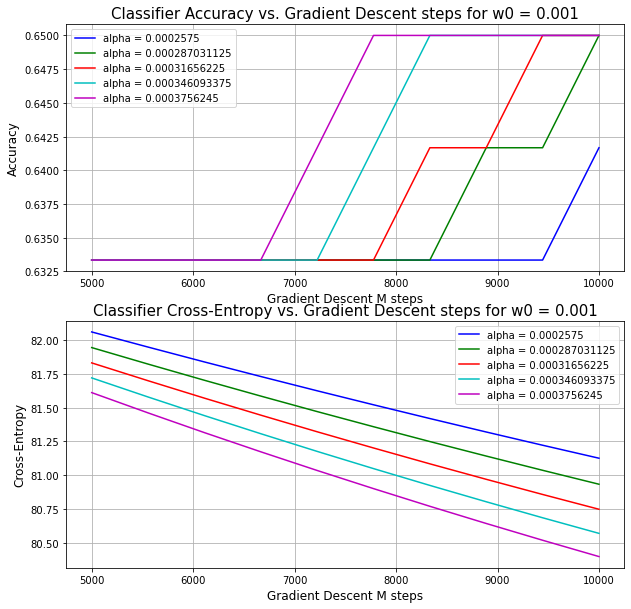

In [31]:
# find the optimum varibles by given data
# alpha between 0.0005005 - 0.00075025 withe 5 values
# alpha between 1000 - 10000 withe 10 values
w0 = np.zeros(data.shape[1])+0.001 # we choose value that close to the data
alphas = np.linspace(0.0002575,0.0003756245,5)
steps = np.linspace(5000 , 10000, 10)
[op_accuracy,op_ce,op_alpha,op_m] = findOptimumVars(w0,X_train,t_train,alphas, steps)



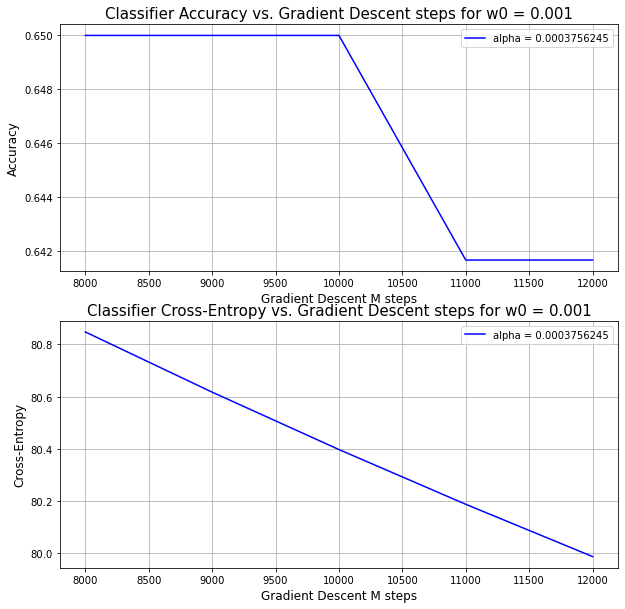

In [35]:
# find the optimum varibles by given data after 1 set check
# alpha between 0.0005005 - 0.00075025 withe 5 values
# alpha between 6000 - 10000 withe 10 values
alphas = np.linspace(0.0003756245,0.0003756245,1)
steps = np.linspace(8000 , 12000, 5)
[op_accuracy,op_ce,op_alpha,op_m] = findOptimumVars(w0,X_train,t_train,alphas, steps)
best_alpha = op_alpha
best_m = op_m

In [36]:
# display accurency, mse of test and train series
print('optimal steps: ' + str(best_m))
print('optimal alpha: ' + str(best_alpha))

w = gradientDescent(w0,X_train,t_train,int(op_m),op_alpha) # set gradient descent with optimal founded params
P_train = probabilityMatrix(X_train,w)
P_test = probabilityMatrix(X_test,w)

# Q3 - c
conf_mat_test = confusionMatrix(X_test,t_test,threshold,P_test)
conf_mat_train = confusionMatrix(X_train,t_train,threshold,P_train)
# print the accuracy of the two series
print('train Accuracy = ' + str(accuracy(conf_mat_train)))
print('Test Accuracy = ' + str(accuracy(conf_mat_test)))

#print the mse of the two series
mse_train = mse(X_train,t_train,w)
mse_test = mse(X_test,t_test,w)
print('mse_train = ' + str(mse_train))
print('mse_test = ' + str(mse_test))

optimal steps: 10000.0
optimal alpha: 0.0003756245
train Accuracy = 0.65
Test Accuracy = 0.425
mse_train = 0.2384875551958304
mse_test = 0.2595220758831504


Text(0.5, 0, 'M')

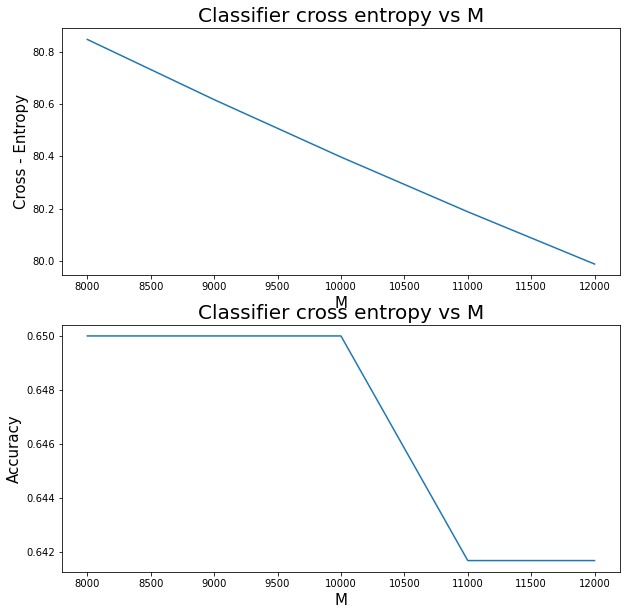

In [37]:
# Q3
#a
exportCSV(w,'TrainedClassiferCoefficients_TrainData2.csv')

#b
acc = np.zeros(len(steps))
ce = np.zeros(len(steps))

for i in range(len(steps)):
    w_ = gradientDescent(w0,X_train,t_train,int(steps[i]),best_alpha)
    Pmatrix = probabilityMatrix(X_train,w_)
    conf_matrix_ = confusionMatrix(X_train,t_train,threshold,Pmatrix)
    ce[i] = crossEntropy(t_train , Pmatrix)
    acc[i] = accuracy(conf_matrix_)

fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,10))


ax[0].plot(steps,ce)
ax[0].set_title('Classifier cross entropy vs M',fontsize=20)
ax[0].set_ylabel('Cross - Entropy',fontsize=15)
ax[0].set_xlabel('M',fontsize=15)
ax[1].plot(steps,acc)
ax[1].set_title('Classifier cross entropy vs M',fontsize=20)
ax[1].set_ylabel('Accuracy',fontsize=15)
ax[1].set_xlabel('M',fontsize=15)

confusion matrix for train series: 
[[44. 26.]
 [16. 34.]]
confusion matrix for test series: 
[[15. 18.]
 [ 5.  2.]]


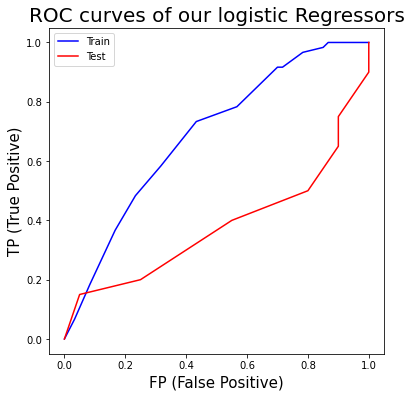

In [38]:
#Q3 - d

print('confusion matrix for train series: \n' + str(conf_mat_train))
print('confusion matrix for test series: \n' + str(conf_mat_test))

[TP_rates_train,FP_rates_train] = ROC(X_train,t_train,P_train)
[TP_rates_test,FP_rates_test] = ROC(X_test,t_test,P_test)
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(FP_rates_train,TP_rates_train,label='Train',c='b')
ax.plot(FP_rates_test,TP_rates_test,label='Test',c='r')
ax.set_title('ROC curves of our logistic Regressors',fontsize=20)
ax.set_xlabel('FP (False Positive)',fontsize=15)
ax.set_ylabel('TP (True Positive)',fontsize=15)
ax.legend()